In [1]:
import Learn2_new as ln
ut = ln.ut # utilities
ef = ln.ef # ERA_Fields_New

# log to stdout
import logging
import sys
import os
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]

# set spacing of the indentation
ut.indentation_sep = '  '

2022-07-04 10:19:37.032799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
In this environment you cannot import Basemap


In [2]:
mylocal = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'
mylocal = '/local/gmiloshe/PLASIM/' 
test = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m','zg500'], 'dataset_years' : 1000, 'year_list' : range(10), 'year_permutation' : range(10), 'mylocal' : mylocal, 'T' : 14}))
test = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m','zg500'], 'preprefix' : '', 'dataset_years' : 1000, 'year_list' : range(10), 'year_permutation' : range(10), 'mylocal' : mylocal, 'T' : 14}))
fields_absolute = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m','zg500'], 'preprefix' : '', 'year_list' : range(10), 'year_permutation' : range(10), 'mylocal' : mylocal, 'T' : 14}))
(_, _, _, lat, lon), _  = ln.prepare_data_and_mask(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),{'fields' : ['t2m','zg500'], 'year_list' : range(10), 'year_permutation' : range(10), 'mylocal' : mylocal, 'T' : 14}))
fields = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m','zg500'], 'year_list' : range(10), 'year_permutation' : range(10), 'mylocal' : mylocal, 'T' : 14}))

load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 0.5 s
  select_years:
  select_years: completed in 0.1 s
  select_lonlat:
  select_lonlat: completed in 0.1 s
  Opening field zg
  monotonize_years:
  monotonize_years: completed in 0.5 s
  select_years:
  select_years: completed in 0.1 s
  select_lonlat:
  select_lonlat: completed in 0.1 s
load_data: completed in 52.7 s
load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 0.5 s
  select_years:
  select_years: completed in 0.1 s
  select_lonlat:
  select_lonlat: completed in 0.1 s
  Opening field zg
  monotonize_years:
  monotonize_years: completed in 0.5 s
  select_years:
  select_years: completed in 0.1 s
  select_lonlat:
  select_lonlat: completed in 0.1 s
load_data: completed in 50.5 s
load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 4.2 s
  select_years:
  select_years: completed in 0.7 s
  select_lonlat:
  select_lonlat: completed i

In [3]:
fields_absolute = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m','zg500'], 'preprefix' : '', 'year_list' : range(500), 'year_permutation' : range(500), 'mylocal' : mylocal, 'T' : 14}))
(_, _, _, lat, lon), _  = ln.prepare_data_and_mask(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),{'fields' : ['t2m','zg500'], 'year_list' : range(10), 'year_permutation' : range(10), 'mylocal' : mylocal, 'T' : 14}))
fields = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m','zg500'], 'year_list' : range(500), 'year_permutation' : range(500), 'mylocal' : mylocal, 'T' : 14}))
import numpy as np
LON, LAT = np.meshgrid(lon,lat)

load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 4.3 s
  select_years:
  select_years: completed in 0.7 s
  select_lonlat:
  select_lonlat: completed in 4.1 s
  Opening field zg
  monotonize_years:
  monotonize_years: completed in 4.1 s
  select_years:
  select_years: completed in 0.7 s
  select_lonlat:
  select_lonlat: completed in 3.7 s
load_data: completed in 54.3 s
prepare_data_and_mask:
  load_data:
    Opening field tas
    monotonize_years:
    monotonize_years: completed in 3.8 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 0.1 s
    Opening field zg
    monotonize_years:
    monotonize_years: completed in 4.1 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 0.1 s
  load_data: completed in 52.0 s
  prepare_XY:
    make_XY:
      make_X:
      make_X: completed in 0.0 s
      assign_labels:
        A_weights = None
        com

assign_labels:
  A_weights = None
  compute_time_average:
  compute_time_average: completed in 0.6 s
  threshold_new = None
assign_labels: completed in 0.7 s


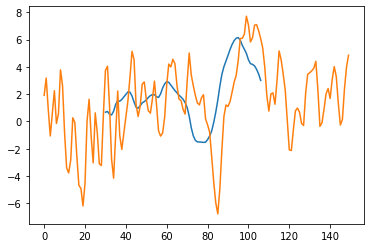

In [9]:
import matplotlib.pyplot as plt
ln.assign_labels(fields['t2m'])
A = fields['t2m'].A.to_numpy().reshape(fields['t2m'].years,-1)
time_series = fields['t2m'].area_integral.to_numpy().reshape(fields['t2m'].years,-1)
plt.plot(range(30,A.shape[1]+30), A[215,:])
plt.plot(time_series[215,:])

In [5]:
ln.assign_labels(fields['t2m'])
A = fields['t2m'].A.to_numpy().reshape(fields['t2m'].years,-1)
print("np.std(A) = ",np.std(A))
A_max, Ti, year_a = ef.a_max_and_ti_postproc(A, A.shape[1])
A_max_sorted = ef.a_decrese(A_max, Ti, year_a)
A_max_sorted

assign_labels:
  A_weights = None
  compute_time_average:
  compute_time_average: completed in 0.6 s
  threshold_new = None
assign_labels: completed in 0.7 s
np.std(A) =  1.6977311


/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/ERA_Fields_New.py:792: UserWarning: a_max_and_ti_postproc: adjusting length
  warnings.warn('a_max_and_ti_postproc: adjusting length')


[(6.4144926, [30, 219]),
 (6.149161, [65, 215]),
 (6.1326175, [21, 330]),
 (6.040289, [43, 106]),
 (5.9151654, [2, 107]),
 (5.4694924, [43, 141]),
 (5.4396663, [8, 68]),
 (5.343632, [6, 280]),
 (5.326269, [17, 302]),
 (5.0790277, [76, 204]),
 (5.0167294, [45, 160]),
 (4.972892, [69, 240]),
 (4.7204394, [54, 149]),
 (4.6635394, [7, 24]),
 (4.648931, [34, 438]),
 (4.6443586, [76, 375]),
 (4.635789, [47, 191]),
 (4.5700636, [21, 29]),
 (4.5684595, [3, 64]),
 (4.5586443, [66, 406]),
 (4.5507803, [61, 417]),
 (4.505136, [22, 263]),
 (4.4981394, [49, 461]),
 (4.476386, [5, 361]),
 (4.3805957, [1, 358]),
 (4.3727164, [22, 45]),
 (4.359666, [46, 95]),
 (4.346788, [8, 288]),
 (4.299579, [69, 123]),
 (4.2806683, [4, 398]),
 (4.2691355, [20, 206]),
 (4.238116, [2, 223]),
 (4.2151837, [51, 265]),
 (4.184886, [18, 53]),
 (4.1599836, [44, 437]),
 (4.0456, [3, 270]),
 (4.039687, [1, 262]),
 (4.0348697, [63, 40]),
 (4.012705, [29, 354]),
 (4.0037403, [74, 128]),
 (3.9900255, [74, 328]),
 (3.9884863, [

/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/cartopy_plots.py:134: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


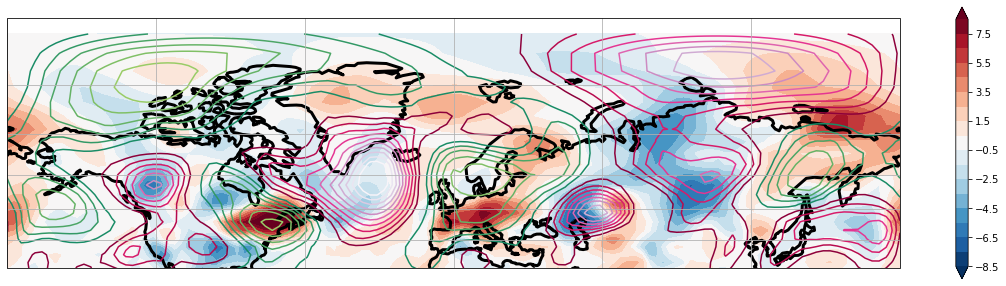

In [18]:
import numpy as np
LON, LAT = np.meshgrid(lon,lat)
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeat
data_proj = ccrs.PlateCarree()
import cartopy_plots as cplt
import matplotlib.pyplot as plt
t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(20, 5))
i = 0
spec2 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig2)
m = fig2.add_subplot(spec2[0,i], projection=ccrs.Miller(central_longitude=0.0))
#m = fig2.add_subplot(spec2[0,i], projection=ccrs.Orthographic(central_latitude=90))

#ax.append(m)
m.set_extent([-180,180, 30, 90], crs=data_proj)
cplt.geo_contourf(m, LON, LAT, fields['t2m'].var[215,95,:,:], levels=t2mlevels, cmap="RdBu_r", title=None, put_colorbar=True, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
#cplt.geo_contourf(m, LON, LAT, fields['t2m'].mask, levels=t2mlevels, cmap="RdBu_r", title=None, put_colorbar=True, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
cplt.geo_contour(m, LON, LAT, fields['zg500'].var[215,95,:,:], levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)
m.coastlines(linewidth=3)
fig2.savefig('./Images/synoptic_situation.png',bbox_inches='tight',dpi=200)

NotImplementedError: Use cartopy_plots.animate

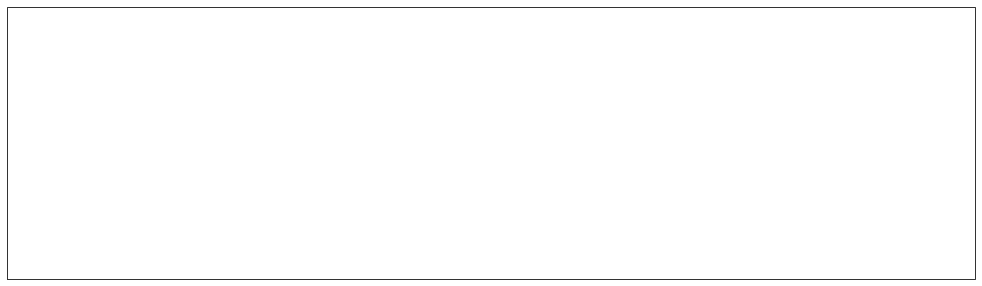

In [8]:
t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(20, 5))
i = 0
spec2 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig2)
m = fig2.add_subplot(spec2[0,i], projection=ccrs.Miller(central_longitude=0.0))
#ax.append(m)
m.set_extent([-180,180, 30, 90], crs=data_proj)
ef.absolute_animate(i,m, m, 0, 0, (LON), (LAT),  fields['t2m'].var[219,30+40,:,:], t2mlevels, fields['zg500'].var[219,30+40,:,:], zg500levels, "inferno", "temperature  and geopotential")

### Loading 500 years

I am loading 500 years just in case I need to check something quickly

In [2]:
ln.get_default_params(ln.prepare_data, recursive=True)

{'load_data_kwargs': {'dataset_years': 8000,
  'year_list': None,
  'sampling': '',
  'Model': 'Plasim',
  'area': 'France',
  'filter_area': 'France',
  'lon_start': -64,
  'lon_end': 64,
  'lat_start': 0,
  'lat_end': 22,
  'mylocal': '/local/gmiloshe/PLASIM/',
  'fields': ['t2m', 'zg500', 'mrso_filtered']},
 'prepare_XY_kwargs': {'do_premix': False,
  'premix_seed': 0,
  'do_balance_folds': True,
  'nfolds': 10,
  'year_permutation': None,
  'flatten_time_axis': True,
  'return_time_series': False,
  'make_XY_kwargs': {'label_field': 't2m',
   'time_start': 30,
   'time_end': 120,
   'T': 14,
   'tau': 0,
   'percent': 5,
   'threshold': None,
   'label_period_start': None,
   'label_period_end': None,
   'A_weights': None},
  'roll_X_kwargs': {'roll_axis': 'lon', 'roll_steps': 0}}}

In [19]:


(X, Y, year_permutation, lat, lon, time_series), mask  = ln.prepare_data_and_mask(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),{'return_time_series' : True, 'myinput':'Y', 
                                             'fields': ['t2m_inter_filtered','zg500_inter','mrso_inter_filtered'], 'label_field' : 't2m_inter', 'year_list': 'range(100)', 
                                             'T' : 15, 'A_weights' : [3,0,0, 3,0,0, 3,0,0, 3,0,0, 3,0,0],
                                               'print_summary' : False, 'k1': 0.9 , 'k2':0.1, 'field_weights': [20., 1., 20.],'mask_area':'France', 'usemask' : True, 'Z_DIM': 8, #16, #8, #64,
                                                'N_EPOCHS': 2,'batch_size': 128, 'checkpoint_every': 1, 'lr': 5e-4, 'epoch_tol': None, 'lr_min' : 5e-4, 'lat_start' : 0, 'lat_end' : 24, 'lon_start' : 98, 'lon_end' : 18, 
                                                #'lat_start' : 4, 'lat_end' : 22, 'lon_start' : 101, 'lon_end' : 15, 
                                                'time_start' : 15, 'label_period_start' : 30,  'time_end' : 134, 'label_period_end' : 120,
                                                #'lat_0' : 0, 'lat_1' : 24, 'lon_0' : (64-28), 'lon_1' : (64+15), 'coef_out' : 0.1, 'coef_in' : 1, 
                                                # 'coef_class' : 0.1, 'class_type' : 'mean', 'L2factor' : 1e-9,
                                                'print_summary' : True,})) #, 'time_start' : 0, 'label_period_start' : 30})) 
import numpy as np
LON, LAT = np.meshgrid(lon,lat)

prepare_data_and_mask:
  load_data:
    Opening field tas
    monotonize_years:
    monotonize_years: completed in 3.8 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 0.4 s
    Opening field zg
    monotonize_years:
    monotonize_years: completed in 3.9 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 0.4 s
    Opening field mrso
    monotonize_years:
    monotonize_years: completed in 3.8 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 0.4 s
  load_data: completed in 1 min 16.1 s
  prepare_XY:
    make_XY:
      make_X:
      make_X: completed in 0.1 s
      assign_labels:
        A_weights = [3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0]
        compute_time_average:
        	compute_area_integral:
        	compute_area_integral: completed in 0.1 s
        compute_time_average: completed in 0.5 s
        com

In [4]:
import numpy as np
mylocal = '/local/gmiloshe/PLASIM/'
X2, Y2, year_permutation2, lat2, lon2 = ln.prepare_data(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),{'fields':['t2m_inter'], 'label_field':'t2m_inter', 'lat_start' : 0, 'lat_end' : 24, 'lon_start' : 98, 'lon_end' : 18,  'T' : 15, 'dataset_years': 8000, 'year_list': range(500),  'mylocal' : mylocal, 'time_start' : 0, 'label_period_start' : 30, 'A_weights' : [3,0,0, 3,0,0, 3,0,0, 3,0,0, 3,0,0]})) 
LON2, LAT2 = np.meshgrid(lon2,lat2)

prepare_data:
  load_data:
    Opening field tas
    monotonize_years:
    monotonize_years: completed in 4.3 s
    select_years:
    select_years: completed in 0.8 s
    select_lonlat:
    select_lonlat: completed in 2.6 s
  load_data: completed in 29.6 s
  prepare_XY:
    make_XY:
      make_X:
      make_X: completed in 0.1 s
      assign_labels:
        A_weights = [3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0]
        compute_time_average:
        	compute_area_integral:
        	compute_area_integral: completed in 0.6 s
        compute_time_average: completed in 2.5 s
        compute_time_average:
        compute_time_average: completed in 2.0 s
        threshold_new = 2.742728328704834
      assign_labels: completed in 4.6 s
    make_XY: completed in 4.7 s
    roll_X:
    roll_X: completed in 0.0 s
    Mixing
     label_period_start = 30 ;time_start = 0 ;time_end = 120 ;label_period_end = 120 
    Y.shape = (500, 106), from 30 to 106 
    balance_folds:
      Balancing folds
    

In [5]:
import numpy as np
mylocal = '/local/gmiloshe/PLASIM/'
X3, Y3, year_permutation3, lat3, lon3 = ln.prepare_data(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),{'fields':['t2m_inter'], 'label_field':'t2m_inter', 'lat_start' : 0, 'lat_end' : 24, 'lon_start' : 98, 'lon_end' : 18,  'T' : 15, 'dataset_years': 8000, 'year_list': range(500), 'mylocal' : mylocal, 'time_start' : 5, 'label_period_start' : 30,  'time_end' : 120, 'label_period_end' : 120,  'A_weights' : [3,0,0, 3,0,0, 3,0,0, 3,0,0, 3,0,0]})) 
LON3, LAT3 = np.meshgrid(lon3,lat3)

prepare_data:
  load_data:
    Opening field tas
    monotonize_years:
    monotonize_years: completed in 3.8 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 2.5 s
  load_data: completed in 24.9 s
  prepare_XY:
    make_XY:
      make_X:
      make_X: completed in 0.1 s
      assign_labels:
        A_weights = [3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0]
        compute_time_average:
        	compute_area_integral:
        	compute_area_integral: completed in 0.5 s
        compute_time_average: completed in 2.3 s
        compute_time_average:
        compute_time_average: completed in 1.8 s
        threshold_new = 2.742728328704834
      assign_labels: completed in 4.1 s
    make_XY: completed in 4.2 s
    roll_X:
    roll_X: completed in 0.0 s
    Mixing
     label_period_start = 30 ;time_start = 5 ;time_end = 120 ;label_period_end = 120 
    Y.shape = (500, 101), from 25 to 101 
    balance_folds:
      Balancing folds
    

In [6]:
import numpy as np
mylocal = '/local/gmiloshe/PLASIM/'
X4, Y4, year_permutation4, lat4, lon4 = ln.prepare_data(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),{'fields':['t2m_inter'], 'label_field':'t2m_inter', 'lat_start' : 0, 'lat_end' : 24, 'lon_start' : 98, 'lon_end' : 18,  'T' : 15, 'dataset_years': 8000, 'year_list': range(500), 'mylocal' : mylocal, 'time_start' : 15, 'label_period_start' : 30,  'time_end' : 134, 'label_period_end' : 120,  'A_weights' : [3,0,0, 3,0,0, 3,0,0, 3,0,0, 3,0,0]})) 
LON4, LAT4 = np.meshgrid(lon4,lat4)

prepare_data:
  load_data:
    Opening field tas
    monotonize_years:
    monotonize_years: completed in 4.0 s
    select_years:
    select_years: completed in 0.7 s
    select_lonlat:
    select_lonlat: completed in 2.4 s
  load_data: completed in 24.2 s
  prepare_XY:
    make_XY:
      make_X:
      make_X: completed in 0.1 s
      assign_labels:
        A_weights = [3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0]
        compute_time_average:
        	compute_area_integral:
        	compute_area_integral: completed in 0.5 s
        compute_time_average: completed in 2.3 s
        compute_time_average:
        compute_time_average: completed in 1.8 s
        threshold_new = 2.742728328704834
      assign_labels: completed in 4.1 s
    make_XY: completed in 4.2 s
    roll_X:
    roll_X: completed in 0.0 s
    Mixing
     label_period_start = 30 ;time_start = 15 ;time_end = 134 ;label_period_end = 120 
    Y.shape = (500, 105), from 15 to 91 
    balance_folds:
      Balancing folds
    

In [7]:
np.array(year_permutation4)

array([ 68, 106,  31, 365, 375, 461, 427, 276, 431, 270, 358, 258, 310,
       242,  92, 499, 498, 495, 494, 493, 492, 491, 490, 489, 488, 486,
       485, 483, 482, 481, 480, 479, 478, 477, 476, 475, 474, 473, 472,
       471, 470, 468, 467, 466, 465, 464, 462, 460, 459, 458, 280, 169,
       296, 437,  64, 353, 398, 262, 364, 205, 167, 217, 261, 221,  83,
       457, 456, 455, 452, 451, 450, 448, 447, 446, 445, 444, 443, 442,
       441, 434, 433, 430, 428, 426, 423, 422, 421, 420, 419, 418, 416,
       414, 413, 412, 410, 409, 408, 407, 405, 404, 149, 141,   0, 496,
       361,  73, 436, 233,  50, 244,  79, 161, 136, 187,  80, 403, 402,
       401, 400, 399, 397, 396, 395, 394, 392, 391, 389, 388, 387, 386,
       385, 384, 383, 382, 381, 378, 376, 374, 373, 372, 370, 369, 368,
       366, 363, 360, 357, 356, 352, 351,  29, 189, 215,  24, 327,  61,
       254,  56, 339, 190,  30,  91, 103, 183,  22, 350, 348, 347, 346,
       344, 343, 341, 338, 337, 336, 334, 333, 332, 326, 325, 32

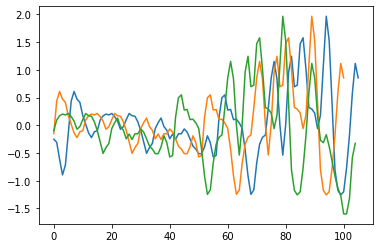

In [8]:
import matplotlib.pyplot as plt
plt.plot(X2.reshape(500,-1,LON2.shape[0],LON2.shape[1])[499,:,0,0])
plt.plot(X3.reshape(500,-1,LON2.shape[0],LON2.shape[1])[499,:,0,0])
plt.plot(X4.reshape(500,-1,LON2.shape[0],LON2.shape[1])[499,:,0,0])

In [9]:
X2.reshape(500,-1,LON2.shape[0],LON2.shape[1])[499,5,0,0], X3.reshape(500,-1,LON2.shape[0],LON2.shape[1])[499,0,0,0]

(-0.14813606, -0.14813606)

In [6]:
np.where(((Y-Y2).reshape(500,106))==1), np.where(((Y-Y2).reshape(500,106))==-1), (X[0,0,0,0]+X[1,0,0,0]+X[2,0,0,0])/3,   X2[0,0,0,0]

((array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 0.3144933780034383,
 0.3144931)

In [7]:
X2.reshape(len(X2),LON2.shape[0]*LON2.shape[1]).shape

(53000, 1152)

In [8]:
from scipy.spatial import cKDTree
n_neighbors = 10

tree = cKDTree(X2.reshape(len(X2),LON2.shape[0]*LON2.shape[1])[:10000])
dist, ind = tree.query(X2.reshape(len(X2),LON2.shape[0]*LON2.shape[1])[:5000], k=n_neighbors,n_jobs = 3)

/tmp/ipykernel_768645/976586607.py:5: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  dist, ind = tree.query(X2.reshape(len(X2),LON2.shape[0]*LON2.shape[1])[:5000], k=n_neighbors,n_jobs = 3)


In [12]:
X4.reshape(len(X4),LON4.shape[0]*LON4.shape[1])[:10000].shape, X4.reshape(len(X4),LON4.shape[0]*LON4.shape[1])[:5000].shape

((10000, 1152), (5000, 1152))

In [13]:
X4.reshape(len(X4),-1).shape

(52500, 1152)

In [21]:
X4.shape[1],X4.shape[2]

(24, 48)

In [17]:
(time_end-time_start-T+1-3)*len(X4)//(time_end-time_start-T+1)

51000

In [23]:
kwargs = {'fields':['t2m_inter'], 'label_field':'t2m_inter', 'lat_start' : 0, 'lat_end' : 24, 'lon_start' : 98, 'lon_end' : 18,  'T' : 15, 'dataset_years': 8000, 'year_list': range(500), 'mylocal' : mylocal, 'time_start' : 15, 'label_period_start' : 30,  'time_end' : 134, 'label_period_end' : 120,  'A_weights' : [3,0,0, 3,0,0, 3,0,0, 3,0,0, 3,0,0]}
time_start = ut.extract_nested(ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),kwargs), 'time_start')
time_end = ut.extract_nested(ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),kwargs), 'time_end')
T = ut.extract_nested(ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),kwargs), 'T')
X4min3d = X4.reshape(len(X4)//(time_end-time_start-T+1),time_end-time_start-T+1,X4.shape[1]*X4.shape[2])[:,:-3,:].reshape(-1,X4.shape[1]*X4.shape[2])
#len(X2)//(time_end-time_start-T+1)

In [19]:
X4min3d.shape

(51000, 1152)

In [22]:
X4.reshape(len(X4),-1).shape, 51000//500, time_end-time_start-T+1

((52500, 1152), 102, 105)

In [11]:
from scipy.spatial import cKDTree
tree = cKDTree(X4min3d[:,:8])
dist, ind = tree.query(X4.reshape(len(X4),-1)[:,:8], k=1000,n_jobs = 3)
ind_new = (ind // time_end-time_start-T+1 - 3)*(3) + ind

/tmp/ipykernel_896699/456463767.py:3: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  dist, ind = tree.query(X4.reshape(len(X4),-1)[:,:8], k=1000,n_jobs = 3)


In [28]:
dict(zip(range(len([{0: np.array([2,3]), 1: np.array([3,4])}, {0: np.array([23,33]), 1: np.array([33,43])}])),[{0: np.array([2,3]), 1: np.array([3,4])}, {0: np.array([23,33]), 1: np.array([33,43])}]))

{0: {0: array([2, 3]), 1: array([3, 4])},
 1: {0: array([23, 33]), 1: array([33, 43])}}

In [31]:
import pickle
open_file = open('../VAE/xmodels/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/analogues.pkl', "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [36]:


open_file = open('../VAE/xmodels/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/analogues.pkl', "wb")
pickle.dump(dict(zip(range(len(loaded_list)),loaded_list)), open_file)
open_file.close()

Let's make a sample plot of this

/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/cartopy_plots.py:134: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


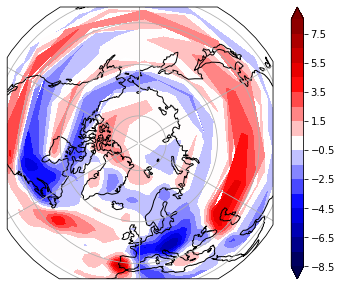

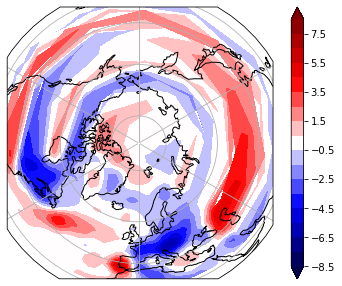

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeat
data_proj = ccrs.PlateCarree()
import cartopy_plots as cplt

t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(30, 5))
i = 0
time = 3000
spec2 = gridspec.GridSpec(ncols=4, nrows=1, figure=fig2)
m = fig2.add_subplot(spec2[0,i], projection=ccrs.Orthographic(central_latitude=90))
#ax.append(m)
m.set_extent([-180,180, 30, 90], crs=data_proj)
cplt.geo_contourf(m, LON, LAT, (X[time,:,:,0]+X[time+1,:,:,0]+X[time+2,:,:,0])/3, levels=t2mlevels, cmap="seismic", title=None, put_colorbar=True, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
#cplt.geo_contour(m, LON, LAT, X[12,:,:,0], levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)

LON2, LAT2 = np.meshgrid(lon2,lat2)
fig2 = plt.figure(figsize=(30, 5))
i = 0
spec2 = gridspec.GridSpec(ncols=4, nrows=1, figure=fig2)
m = fig2.add_subplot(spec2[0,i], projection=ccrs.Orthographic(central_latitude=90))
#ax.append(m)
m.set_extent([-180,180, 30, 90], crs=data_proj)
cplt.geo_contourf(m, LON2, LAT2, X2[time,:,:,0], levels=t2mlevels, cmap="seismic", title=None, put_colorbar=True, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
#cplt.geo_contour(m, LON, LAT, X[12,:,:,0], levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)

In [26]:
mylat = 15
mylon = 0
(X[time,mylat,mylon,0]+X[time+1,mylat,mylon,0]+X[time+2,mylat,mylon,0])/3 - X2[time,mylat,mylon,0]

1.0152657826778544e-05

In [10]:
ln.get_default_params(ln.load_data, recursive=True)

{'dataset_years': 8000,
 'year_list': None,
 'sampling': '',
 'Model': 'Plasim',
 'area': 'France',
 'filter_area': 'France',
 'lon_start': -64,
 'lon_end': 64,
 'lat_start': 0,
 'lat_end': 22,
 'mylocal': '/local/gmiloshe/PLASIM/',
 'fields': ['t2m', 'zg500', 'mrso_filtered']}

In [2]:
mylocal = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'
mylocal = '/local/gmiloshe/PLASIM/' 
t2m = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields' : ['t2m'], 'year_list' : range(500), 'year_permutation' : range(500), 'mylocal' : mylocal, 'roll_steps': 64, 'T' : 15}))
t2m_inter = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields':['t2m_inter'], 'label_field':'t2m_inter', 'year_list': range(500), 'year_permutation' : range(500), 'mylocal' : mylocal, 'roll_steps': 64, 'T' : 15, 'weights' : [1,0,0, 1,0,0, 1,0,0, 1,0,0, 1,0,0]}))

load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 4.1 s
  select_years:
  select_years: completed in 0.8 s
  select_lonlat:
  select_lonlat: completed in 3.8 s
load_data: completed in 34.1 s
load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 4.6 s
  select_years:
  select_years: completed in 0.7 s
  select_lonlat:
  select_lonlat: completed in 3.6 s
load_data: completed in 30.8 s


In [11]:
t2m_inter['t2m_inter'].field.coords['time']

<xarray.DataArray 'time' (time: 74000)>
array([cftime.Datetime360Day(0, 5, 2, 10, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(0, 5, 3, 10, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(0, 5, 4, 10, 30, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(499, 9, 27, 10, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(499, 9, 28, 10, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(499, 9, 29, 10, 30, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0000-05-02 10:30:00 ... 0499-09-29 10:30:00

In [22]:
(t2m['t2m'].var[0,0,0,0]+t2m['t2m'].var[0,1,0,0]+t2m['t2m'].var[0,2,0,0])/3

0.6951718330383301

In [21]:
t2m_inter['t2m_inter'].var[0,0,0,0],t2m_inter['t2m_inter'].var[0,1,0,0]

(0.6951719, 1.0279249)

In [51]:
t2m_inter['t2m_inter'].field.time.dt.dayofyear[0]+30, t2m['t2m'].field.time.dt.dayofyear[0]

(<xarray.DataArray 'dayofyear' ()>
 array(152)
 Coordinates:
     time     object 0000-05-02 10:30:00,
 <xarray.DataArray 'dayofyear' ()>
 array(121)
 Coordinates:
     time     object 0000-05-01 10:30:00)

In [54]:

t2m_inter['t2m_inter'].area_integral.sel(time=t2m_inter['t2m_inter'].area_integral.time.dt.dayofyear.isin(np.arange(10+t2m_inter['t2m_inter'].field.time.dt.dayofyear[0], 11+t2m_inter['t2m_inter'].field.time.dt.dayofyear[0])))

<xarray.DataArray (time: 500)>
array([-3.1374388 ,  1.9969548 ,  0.8176644 , -1.599802  ,  3.711288  ,
       -0.24000852, -2.8933964 , -0.9645912 , -1.642015  , -0.8032627 ,
        1.64291   ,  6.2121806 ,  0.41728985,  1.1418895 ,  0.7242142 ,
        1.0454984 ,  2.8728933 ,  3.3049653 , -0.5607983 ,  4.3280773 ,
       -7.9470987 , -0.02226496,  1.6490576 ,  1.065766  ,  2.430105  ,
       -0.6675175 ,  5.1074185 , -1.1053338 , -0.64231277, -2.696419  ,
       -0.08752835, -1.8712158 , -2.6755314 ,  1.0253739 ,  3.128214  ,
        1.9515688 ,  0.21576875,  3.9052215 ,  1.790316  , -3.6615324 ,
        0.07905743,  0.28188717,  0.1722849 ,  1.8249375 , -0.6913817 ,
        2.4441016 , -1.6685051 , -5.126788  , -1.4716916 , -2.2413688 ,
        0.07121944,  2.778849  , -1.0035211 , -3.2596576 ,  0.8396368 ,
       -5.976754  ,  4.0236816 , -1.3067355 , -2.9403129 , -0.985876  ,
        1.7612953 , -0.18821636,  1.1516094 , -0.71610457,  1.6363995 ,
        0.9608917 , -0.1808012 , -3.8413613 ,  2.6912522 ,  3.0087368 ,
       -3.4773066 ,  2.8936856 , -2.3800774 , -1.0334802 ,  1.0634791 ,
        2.7385633 , -0.57870054,  1.2894747 , -2.0170555 , -0.42225742,
        1.0677872 ,  1.4677057 ,  0.36797932,  3.3864403 , -0.5288645 ,
       -2.2452326 , -3.8890343 , -0.28898948, -2.3158083 ,  2.3367734 ,
       -0.8268639 ,  0.5238571 ,  1.267798  , -0.2678214 ,  2.3323903 ,
        6.476797  ,  2.4374254 , -1.4449575 , -0.2631441 ,  2.165072  ,
...
       -0.11932477,  2.3140252 ,  4.7971773 ,  1.8147935 , -0.28111333,
       -0.07769093,  0.87362176, -1.1941978 ,  3.4239144 ,  1.1651711 ,
       -1.5646236 ,  1.1800609 , -5.580142  , -2.6842976 ,  1.522574  ,
        0.05424416,  0.84569067, -0.68013316, -2.9802833 , -0.4320395 ,
        3.0924778 , -3.750176  , -0.93722063, -2.3845634 ,  3.8011765 ,
       -2.927722  ,  1.7578328 ,  3.9777677 ,  1.16899   ,  0.7322153 ,
       -4.695784  ,  0.63652635,  1.99808   , -0.95811963,  1.9965497 ,
        1.7512765 ,  2.7471414 , -2.770837  ,  3.7969675 , -0.19348392,
       -1.1850002 ,  2.1243005 , -1.9048271 ,  0.6731678 , -0.02543315,
        3.8343968 , -0.3111723 ,  3.0777311 , -1.3521549 ,  0.562792  ,
       -2.5581155 , -1.5867759 , -2.7060218 , -1.5524266 , -1.8430054 ,
       -2.6676304 ,  1.2775735 , -0.16686976,  4.9238825 ,  2.2767406 ,
        1.7102427 ,  0.3300344 ,  1.2671251 , -2.2882428 , -0.30064788,
       -0.78144205, -3.092043  , -5.8522863 ,  3.2077894 ,  1.428957  ,
        0.4671105 , -1.5496867 , -2.157148  , -3.345739  ,  0.52866125,
       -0.01274599,  1.5838101 , -0.2266724 ,  0.91629136,  2.3751252 ,
       -1.402882  , -2.0250967 ,  3.7422624 ,  1.6252861 , -4.655034  ,
       -3.1468077 ,  0.12198859, -6.6157537 , -1.2260776 , -1.7675242 ,
       -2.0160847 , -1.2564838 , -3.993463  , -3.0179987 , -2.9365582 ],
      dtype=float32)
Coordinates:
  * time     (time) object 0000-05-12 10:30:00 ... 0499-05-12 10:30:00

In [40]:
import numpy as np
t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(121, 122)))

<xarray.DataArray (time: 500)>
array([ 1.29338300e+00,  1.54353523e+00, -2.28229809e+00,  1.48848200e+00,
       -4.57135111e-01, -6.72621059e+00,  1.67876017e+00,  1.92891017e-01,
        3.43230993e-01, -4.32584572e+00, -6.80327797e+00,  6.37505531e+00,
        1.31527257e+00,  2.61328220e+00,  6.79839015e-01, -4.07070923e+00,
        2.63314533e+00, -1.09788072e+00, -3.57574642e-01, -6.07396841e-01,
       -2.33842111e+00,  4.16568309e-01,  5.41393900e+00, -3.45885485e-01,
        5.64122295e+00, -2.94147158e+00, -5.87679923e-01, -1.86727226e+00,
       -1.82786143e+00, -1.21553433e+00,  1.57226837e+00,  2.87754345e+00,
       -3.18805528e+00,  1.93241820e-01,  3.66131210e+00, -5.54498863e+00,
        2.69005203e+00,  4.14556950e-01,  7.12837100e-01, -7.67860770e-01,
        1.06445682e+00,  2.30271339e-01,  3.54329300e+00, -1.54477608e+00,
       -3.69076490e+00, -1.05121523e-01,  1.80290270e+00,  1.66612005e+00,
        1.51665121e-01, -3.12822747e+00,  5.06106436e-01, -2.62689829e+00,
       -6.64153457e-01,  1.02486730e+00,  1.62501383e+00, -3.20778418e+00,
       -2.39033508e+00,  7.73452997e-01, -4.92452431e+00,  1.15696013e+00,
        3.32651925e+00,  3.36409736e+00, -3.30414438e+00, -7.05747545e-01,
       -7.79526681e-03,  8.97728443e-01, -4.48206604e-01, -6.35647535e-01,
        3.57956678e-01,  2.49577022e+00,  5.60571432e-01,  3.96764851e+00,
       -9.12006646e-02,  2.83791256e+00, -4.69467926e+00, -2.39135075e+00,
        1.48752660e-01, -2.31046057e+00, -1.96356997e-01,  1.14630091e+00,
...
        5.37147760e-01,  4.19043350e+00, -3.79119420e+00, -2.99705076e+00,
       -4.77356434e+00,  2.18211675e+00,  1.17130232e+00,  1.04541492e+00,
        3.49034834e+00,  2.23746228e+00, -2.66903853e+00,  2.52993059e+00,
        1.28105390e+00,  7.88176537e-01,  2.81306887e+00, -2.19930601e+00,
       -3.30045342e+00,  1.20426726e+00, -1.92991948e+00,  1.83687043e+00,
       -2.28908014e+00,  8.29996407e-01, -5.21559048e+00, -2.73728871e+00,
        2.22991300e+00, -1.21128023e+00, -8.76841962e-01, -7.83589005e-01,
       -3.69280648e+00,  4.30632114e-01,  2.14527607e+00, -1.55790329e+00,
       -3.49349260e+00,  1.73894799e+00, -2.13987142e-01, -9.37038243e-01,
        3.45713544e+00,  2.69951963e+00, -2.53472447e+00,  2.62343431e+00,
        1.53216612e+00,  4.64997816e+00,  8.46133053e-01, -9.89291847e-01,
        3.02714467e+00, -5.89487612e-01, -3.56049466e+00,  3.26672840e+00,
       -1.12930536e+00,  2.39168882e-01,  9.76744056e-01,  2.18830562e+00,
        2.21588206e+00, -4.14464426e+00, -2.14428449e+00,  3.34162474e+00,
        9.28200781e-01,  3.48029673e-01, -1.21124721e+00,  1.82886147e+00,
        1.21488667e+00,  1.72530580e+00,  1.95110500e+00,  7.95848787e-01,
       -4.09295321e+00, -5.96271574e-01,  3.31018162e+00, -1.36098611e+00,
       -1.66464829e+00,  3.19010901e+00, -2.18687630e+00,  1.50166130e+00,
        5.97111821e-01,  2.44321966e+00, -4.45094156e+00,  2.18185496e+00],
      dtype=float32)
Coordinates:
  * time     (time) object 0000-05-01 10:30:00 ... 0499-05-01 10:30:00

assign_labels:
  A_weights = None
  compute_time_average:
  compute_time_average: completed in 0.7 s
  compute_time_average:
  compute_time_average: completed in 0.7 s
  threshold_new = 2.7427294
assign_labels: completed in 1.4 s
assign_labels:
  A_weights = [3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0]
  compute_time_average:
  compute_time_average: completed in 1.9 s
  compute_time_average:
  compute_time_average: completed in 1.9 s
  threshold_new = 2.7427280485630035
assign_labels: completed in 3.8 s
np.max(labels-labels_inter) = 0,  np.min(labels-labels_inter) = 0


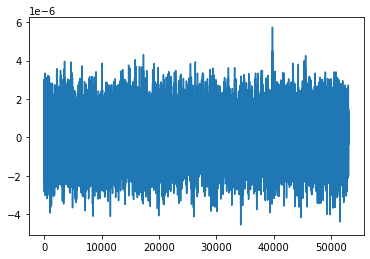

In [47]:
labels = ln.assign_labels(t2m['t2m'], time_start=0, T=15, percent=5, label_period_start=30)
labels_inter = ln.assign_labels(t2m_inter['t2m_inter'], time_start=0, T=15, percent=5, label_period_start=30, A_weights=[3,0,0, 3,0,0, 3,0,0, 3,0,0, 3,0,0])
import matplotlib.pyplot as plt
plt.plot(t2m['t2m'].A.to_numpy() - t2m_inter['t2m_inter'].A.to_numpy())
print(f"{np.max(labels-labels_inter) = },  {np.min(labels-labels_inter) = }")

0

In [27]:
t2m_inter_filtered = ln.load_data(**ut.set_values_recursive(ln.get_default_params(ln.load_data, recursive=True), {'fields':['t2m_inter_filtered'], 'label_field':'t2m_inter', 'year_list': range(500), 'year_permutation' : range(500), 'mylocal' : mylocal, 'roll_steps': 64, 'T' : 15, 'weights' : [1,0,0, 1,0,0, 1,0,0, 1,0,0, 1,0,0]}))

load_data:
  Opening field tas
  monotonize_years:
  monotonize_years: completed in 5.4 s
  select_years:
  select_years: completed in 0.9 s
  select_lonlat:
  select_lonlat: completed in 3.4 s
load_data: completed in 31.3 s


In [8]:
ln.assign_labels(t2m_inter['t2m_inter'], time_start=30, time_end=120, T=15, percent=5, threshold=None, label_period_start=None, label_period_end=None, weights=[1,1,1, 1,1,1, 1,0,0, 1,0,0, 1,0,0])
t2m_inter['t2m_inter'].A

assign_labels:
  compute_time_average:
  compute_time_average: completed in 2.3 s
  threshold_new = None
assign_labels: completed in 2.3 s


<xarray.DataArray (time: 38000)>
array([-0.18874343, -0.49704181, -0.74291729, ...,  0.46139432,
        0.34744652,  0.3386466 ])
Coordinates:
  * time     (time) object 0000-06-16 10:30:00 ... 0499-09-01 10:30:00

In [20]:
time_start = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_start')
time_end = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_end')
day0 = t2m['t2m'].field.time.dt.dayofyear[0]
t2m_inter['t2m_inter'].compute_time_average(day_start=day0+time_start, day_end=day0+time_end, T=15, weights=[1,0,0, 1,0,0, 1,0,0, 1,0,0, 1,0,0])

compute_time_average:


TypeError: rolling_reduce_weighted() missing 1 required positional argument: 'T'

In [8]:
time_start = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_start')
time_end = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_end')
day0 = t2m['t2m'].field.time.dt.dayofyear[0]
#series_int = t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end)))
#running_mean = series_int.groupby('time.year').apply(ef.rolling_reduce_weighted, T=5, weights=np.array([1, 0, 1, 0 ,1]))
#running_mean
compute_time_average

<xarray.DataArray (time: 43000)>
array([ 0.96804101,  0.55896645, -0.33211353, ..., -0.63915834,
       -0.48137078,  0.05429424])
Coordinates:
  * time     (time) object 0000-06-05 10:30:00 ... 0499-08-30 10:30:00

In [11]:
time_start = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_start')
time_end = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_end')
day0 = t2m['t2m'].field.time.dt.dayofyear[0]
# series_int = t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end))[::-1]).rolling(time=15, center=False).construct("window_dim")#.mean().dropna('time')[::-1]
series_int = t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end)))
t_avg = lambda a: a[::-1].rolling(time=15, center=False).mean().dropna('time')[::-1]
running = series_int.groupby('time.year').apply(t_avg)

running
#A = t2m_inter['t2m_inter'].compute_time_average(day_start=day0+time_start, day_end=day0+time_end, T=14)


<xarray.DataArray (time: 38000)>
array([-0.33406633, -0.5020727 , -0.6147718 , ...,  0.6383307 ,
        0.5140542 ,  0.44347006], dtype=float32)
Coordinates:
  * time     (time) object 0000-06-01 10:30:00 ... 0499-08-16 10:30:00

In [12]:
np.average(np.array([7,4,5]),weights=np.array([1,0,1]))

6.0

In [13]:
import xarray as xr
def weight_average(a,**kwargs):
    kwargs['axis'] = kwargs['axis'][0] # Otherwise what is being fed into this function could be something of the sort (dim,), which is in conflict with weights
    return np.average(a,**kwargs)

da = xr.DataArray(np.random.randint(9, size=(2, 8)), dims=("a", "b"))
print(f"{da = }")
print(type(da))
rolling = da.rolling(b=3)
rolling.construct("window_dim")
print(f"{rolling = }")
rolling.reduce(weight_average, weights=np.array([1, 0, 1])).dropna('b')*np.sum(np.array([1, 0, 1]))/len(np.array([1,0,1]))


da = <xarray.DataArray (a: 2, b: 8)>
array([[1, 0, 3, 2, 0, 0, 0, 1],
       [0, 0, 5, 2, 0, 8, 3, 4]])
Dimensions without coordinates: a, b
<class 'xarray.core.dataarray.DataArray'>
rolling = DataArrayRolling [b->3]


<xarray.DataArray (a: 2, b: 6)>
array([[1.33333333, 0.66666667, 1.        , 0.66666667, 0.        ,
        0.33333333],
       [1.66666667, 0.66666667, 1.66666667, 3.33333333, 1.        ,
        4.        ]])
Dimensions without coordinates: a, b

In [14]:
rolling = (series_int.rolling(time=15, center=False)).construct("window_dim")
rolling


<xarray.DataArray (time: 45000, window_dim: 15)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,  2.3374112 ],
       [        nan,         nan,         nan, ...,         nan,
         2.3374112 ,  2.7866182 ],
       [        nan,         nan,         nan, ...,  2.3374112 ,
         2.7866182 ,  4.1825147 ],
       ...,
       [ 3.858688  ,  4.50171   ,  3.3211427 , ..., -2.5175164 ,
        -3.1544197 , -0.6539605 ],
       [ 4.50171   ,  3.3211427 ,  0.58458054, ..., -3.1544197 ,
        -0.6539605 ,  1.9945413 ],
       [ 3.3211427 ,  0.58458054, -1.154392  , ..., -0.6539605 ,
         1.9945413 ,  3.442948  ]], dtype=float32)
Coordinates:
  * time     (time) object 0000-06-01 10:30:00 ... 0499-08-30 10:30:00
Dimensions without coordinates: window_dim

In [15]:
rolling = series_int.rolling(time=15, center=False)
rolling.construct("window_dim")
rolling

DataArrayRolling [time->15]

In [16]:
type(series_int)

xarray.core.dataarray.DataArray

In [17]:
time_start = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_start')
time_end = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_end')
day0 = t2m['t2m'].field.time.dt.dayofyear[0]
# series_int = t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end))[::-1]).rolling(time=15, center=False).construct("window_dim")#.mean().dropna('time')[::-1]
series_int = t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end)))
print(f"{series_int = }")
rolling = series_int.rolling(time=5, center=False)
print(f"{rolling = }")
rolling.construct("window_dim")
print(f"{rolling = }")
rolling.reduce(weight_average, weights=np.array([1, 0, 1, 0 ,1])).dropna('time')*np.sum(np.array([1, 0, 1, 0 ,1]))/len(np.array(np.array([1, 0, 1, 0 ,1])))

series_int = <xarray.DataArray (time: 45000)>
array([ 2.3374112,  2.7866182,  4.1825147, ..., -0.6539605,  1.9945413,
        3.442948 ], dtype=float32)
Coordinates:
  * time     (time) object 0000-06-01 10:30:00 ... 0499-08-30 10:30:00
rolling = DataArrayRolling [time->5]
rolling = DataArrayRolling [time->5]


<xarray.DataArray (time: 44996)>
array([ 0.96804101,  0.55896645, -0.33211353, ..., -0.63915834,
       -0.48137078,  0.05429424])
Coordinates:
  * time     (time) object 0000-06-05 10:30:00 ... 0499-08-30 10:30:00

In [16]:
import numpy as np
import xarray as xr
time_start = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_start')
time_end = ut.extract_nested(ln.get_default_params(ln.make_XY), 'time_end')
day0 = t2m_inter['t2m_inter'].field.time.dt.dayofyear[0]
# series_int = t2m['t2m'].area_integral.sel(time=t2m['t2m'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end))[::-1]).rolling(time=15, center=False).construct("window_dim")#.mean().dropna('time')[::-1]
series_int = t2m_inter['t2m_inter'].area_integral.sel(time=t2m_inter['t2m_inter'].area_integral.time.dt.dayofyear.isin(np.arange(day0+time_start, day0+time_end)))

def weight_average(*a,**kwargs):
    '''
        Perform weighted average
    '''
    kwargs['axis'] = kwargs['axis'][0] # Otherwise what is being fed into this function could be something of the sort (dim,), which is in conflict with weights
    return np.average(*a,**kwargs)

def rolling_reduce_weighted(my_a:xr.DataArray, T, weights=None):

    #print(f"{my_a = }")
    rolling = my_a.rolling(time=T, center=False)
    #print(f"{rolling = }")
    rolling.construct("window_dim")
    #print(f"{rolling = }")
    return rolling.reduce(weight_average, weights=weights).dropna('time')*np.sum(weights)/len(weights)

#rolling_reduce_weighted(series_int,5, weights=np.array([1, 0, 1, 0 ,1]))
running_mean = series_int.groupby('time.year').apply(rolling_reduce_weighted, T=15, weights=np.array([1,0,0, 1,0,0, 1,0,0, 1,0,0, 1,0,0]))
running_mean

<xarray.DataArray (time: 38000)>
array([-0.11135591, -0.16735734, -0.20492379, ...,  0.21277685,
        0.17135114,  0.14782311])
Coordinates:
  * time     (time) object 0000-06-16 10:30:00 ... 0499-09-01 10:30:00

In [17]:
print(running_mean[100-15+1])
sum = 0
for i in range(0,15,3):
    print(i)
    sum = sum + series_int[100+i]
sum/15

<xarray.DataArray ()>
array(-1.02789284)
Coordinates:
    time     object 0001-06-26 10:30:00
0
3
6
9
12


<xarray.DataArray ()>
array(-1.02789284)
Coordinates:
    time     object 0001-06-24 10:30:00

Now we can do analysis of some of the runs I have performed. They are all located in gmiloshe/
Below we will plot average score as a function of epoch. Here I am not using collective=True so the average score per epoch will be reported as a result. So in principle one could achieve better metrics

Text(0.5, 1.0, '100 yrs, zg500')

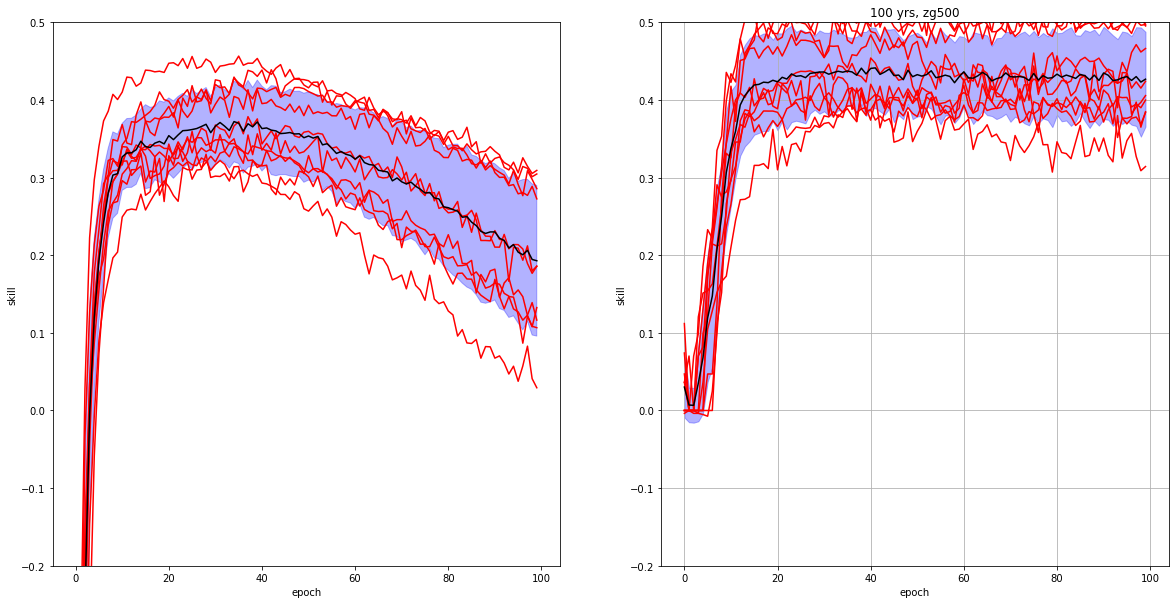

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
percent = 5
df = []
tau = 0
for i in range(10):
    df.append(pd.read_csv(f'models/u1yrs500/0/fold_{i}/history.csv')) #df.append(pd.read_csv(f'models/u1yrs100/0/fold_{i}/history.csv'))
df_concat = pd.concat(df, keys=range(10),names=['fold', None])
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
df_concat['val_CustomSkill'] = (maxskill - df_concat['val_CustomLoss'])/maxskill
fig = plt.figure(figsize=(20, 10))
spec= gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax = []
for i, label in enumerate(['val_CustomSkill', 'val_MCC']):
    ax.append(fig.add_subplot(spec[0,i]))
    dfmean = df_concat.groupby(level=1).mean().loc[:,label]
    dfstd = df_concat.groupby(level=1).std().loc[:,label]
    plt.fill_between(range(len(dfmean)), dfmean.values - dfstd.values, dfmean.values+ dfstd.values, color='blue',alpha=0.3)
    for i in range(10):
        plt.plot((df_concat.loc[i].loc[:,label]),color='red')
    plt.plot(dfmean, color='black')
    plt.ylim(-0.2,0.5)
    plt.xlabel('epoch')
    plt.ylabel('skill')
plt.grid(True)
plt.title('100 yrs, zg500')

In [92]:
runs_grouped_list[0]

{'args': {'fields': ['t2m_filtered', 'mrso_filtered']},
 'runs': [{'name': 'F0--fields__(t2m_filtered,mrso_filtered)',
   'args': {'fields': ['t2m_filtered', 'mrso_filtered']},
   'transfer_learning_from': None,
   'status': 'FAILED',
   'start_time': '2022-05-23 10:17:04',
   'end_time': '2022-05-23 10:17:12',
   'run_time': '7.4 s',
   'run_time_min': 0.12},
  {'name': '1--fields__(t2m_filtered,mrso_filtered)',
   'args': {'fields': ['t2m_filtered', 'mrso_filtered']},
   'transfer_learning_from': None,
   'status': 'COMPLETED',
   'start_time': '2022-05-23 10:18:03',
   'score': 0.14307862073183059,
   'scores': {'fold_0': 0.1518024504184723,
    'fold_1': 0.14107179641723633,
    'fold_2': 0.1341412365436554,
    'fold_3': 0.13774441182613373,
    'fold_4': 0.1381550431251526,
    'fold_5': 0.1443907916545868,
    'fold_6': 0.13609084486961365,
    'fold_7': 0.15910604596138,
    'fold_8': 0.14758439362049103,
    'fold_9': 0.14069919288158417,
    'mean': 0.14307862073183059,
    '

In [64]:
runs = ut.json2dict(f"{folder}/runs.json")
runs_grouped_list = ln.make_groups(runs,config_dict_flat={'tau':0})
config = ut.json2dict(f"{folder}/config.json")
dg = []
taus = []
runs=runs_grouped_list[1]
runs['tau']

[0, -5, -10, -15, -20, -25, -30]

In [106]:
runs_grouped_list[0]

{'args': {'fields': ['t2m_filtered', 'mrso_filtered']},
 'runs': [{'name': 'F0--fields__(t2m_filtered,mrso_filtered)',
   'args': {'fields': ['t2m_filtered', 'mrso_filtered']},
   'transfer_learning_from': None,
   'status': 'FAILED',
   'start_time': '2022-05-23 10:17:04',
   'end_time': '2022-05-23 10:17:12',
   'run_time': '7.4 s',
   'run_time_min': 0.12},
  {'name': '1--fields__(t2m_filtered,mrso_filtered)',
   'args': {'fields': ['t2m_filtered', 'mrso_filtered']},
   'transfer_learning_from': None,
   'status': 'COMPLETED',
   'start_time': '2022-05-23 10:18:03',
   'score': 0.14307862073183059,
   'scores': {'fold_0': 0.1518024504184723,
    'fold_1': 0.14107179641723633,
    'fold_2': 0.1341412365436554,
    'fold_3': 0.13774441182613373,
    'fold_4': 0.1381550431251526,
    'fold_5': 0.1443907916545868,
    'fold_6': 0.13609084486961365,
    'fold_7': 0.15910604596138,
    'fold_8': 0.14758439362049103,
    'fold_9': 0.14069919288158417,
    'mean': 0.14307862073183059,
    '

It looks like we have enough epochs to claim we converged to optimal parameters. Let's put everyting together

F0--fields__(t2m_filtered,mrso_filtered)
1--fields__(t2m_filtered,mrso_filtered)
2--fields__(t2m_filtered,mrso_filtered)--tau__-1
3--fields__(t2m_filtered,mrso_filtered)--tau__-3
4--fields__(t2m_filtered,mrso_filtered)--tau__-5
5--fields__(t2m_filtered,mrso_filtered)--tau__-10
6--fields__(t2m_filtered,mrso_filtered)--tau__-15
7--fields__(zg500)
8--fields__(zg500)--tau__-1
9--fields__(zg500)--tau__-3
10--fields__(zg500)--tau__-5
11--fields__(zg500)--tau__-10
12--fields__(zg500)--tau__-15
13
14--tau__-1
15--tau__-3
16--tau__-5
17--tau__-10
18--tau__-15


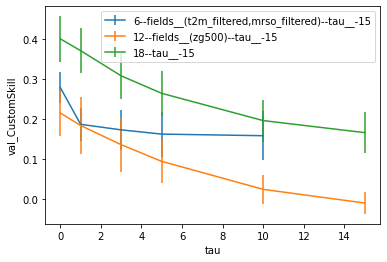

In [109]:
import os
import Learn2_new as ln
from pathlib import Path
import pandas as pd

ut = ln.ut
#folder = 'models/u1yrs500/'
folder = './xmodels/u1yrs500/'
runs = ut.json2dict(f"{folder}/runs.json")
runs_grouped_list = ln.make_groups(runs,config_dict_flat={'tau':0})
config = ut.json2dict(f"{folder}/config.json")


for runs in runs_grouped_list:
    dg = []
    taus = runs['tau']
    for value in runs['runs']:
        print(value['name'])
        if value['status'] != 'FAILED':
            data= pd.read_csv(f"{folder}/{value['name']}/fold_{0}/history.csv")
            #print(tau)
            df = []
            for i in range(10):
                df.append(pd.read_csv(f"{folder}/{value['name']}/fold_{i}/history.csv"))
            #print(f'{len(df) = }')
            dg.append(pd.concat(df, keys=range(10),names=['fold', None]))
    dg_frame = pd.concat(dg, keys=taus,names=['tau','fold', None])
    maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
    dg_frame['val_CustomSkill'] = (maxskill - dg_frame['val_CustomLoss'])/maxskill
    dg_fold_mean = dg_frame.groupby(['tau','epoch']).mean()  # We need to compute fold-wise mean
    dg_idxmax = dg_fold_mean.loc[:,'val_CustomSkill'].groupby(['tau']).idxmax() # Now we compute the indices for which the val_CustomSkill is maximal because we need to apply them to standard deviation as well
    dg_foldmean_maxskill_mean = dg_frame.groupby(['tau','epoch']).mean().loc[dg_idxmax] #Now we are in a position to also compute standard deviation and mean for those columns which correspond to the optimal customskill
    dg_foldmean_maxskill_std = dg_frame.groupby(['tau','epoch']).std().loc[dg_idxmax]
    plt.errorbar(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index,dg_foldmean_maxskill_mean['val_CustomSkill'].values,dg_foldmean_maxskill_std['val_CustomSkill'].values, label=value['name'])
plt.xlabel('tau')
plt.ylabel('val_CustomSkill')
plt.legend(loc='best')
plt.savefig(f'Images/skills.png',dpi=200)

In [105]:
folder = 'models/u10yrs500'
runs = ut.json2dict(f"{folder}/runs.json")
config = ut.json2dict(f"{folder}/config.json")
#print(ut.dict2str(runs))
for key, value in runs.items():
    print(value['name'])

0
1--tau__-5
2--tau__-10
3--tau__-15
4--tau__20
5--tau__-25
6--tau__-30
7--fields__(zg500,mrso_filtered)
8--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-5
9--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-10
10--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-15
11--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-20
12--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-25
13--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-30


In [102]:
runs

{'0': {'name': '0',
  'args': {},
  'transfer_learning_from': None,
  'status': 'COMPLETED',
  'start_time': '2022-03-24 18:06:48',
  'score': 0.12275149822235107,
  'scores': {'fold_0': 0.12484033405780792,
   'fold_1': 0.11022892594337463,
   'fold_2': 0.10792557150125504,
   'fold_3': 0.11694774776697159,
   'fold_4': 0.12915153801441193,
   'fold_5': 0.12959136068820953,
   'fold_6': 0.12960746884346008,
   'fold_7': 0.12829865515232086,
   'fold_8': 0.12931858003139496,
   'fold_9': 0.1216048002243042,
   'mean': 0.12275149822235107,
   'std': 0.007903357925323566},
  'end_time': '2022-03-24 18:20:37',
  'run_time': '13 min 49.1 s',
  'run_time_min': 13.81},
 '1': {'name': '1--tau__-5',
  'args': {'tau': -5},
  'transfer_learning_from': {'run': '0', 'optimal_checkpoint': 71},
  'status': 'COMPLETED',
  'start_time': '2022-03-24 18:20:37',
  'score': 0.1492719605565071,
  'scores': {'fold_0': 0.15401947498321533,
   'fold_1': 0.142021045088768,
   'fold_2': 0.14052891731262207,
   